In [1]:
cd ..

/home/pierreo/semisupervised


In [2]:
import numpy as np
from module.quadrature import Quadrature, QuadratureExplorationBis
from botorch.models import SingleTaskGP
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from module.utils import nearestPD, EI
from botorch.test_functions.synthetic import Ackley, Rosenbrock, Rastrigin


def plot_GP_fit(model, distribution, train_X, targets, obj, normalize=False, lb=-10., up=10., mean_Y=None, std_Y=None):
    """ Plot the figures corresponding to the Gaussian process fit
    """
    model.eval()
    model.likelihood.eval()
    test_x = torch.linspace(lb, up, 200, device=train_X.device, dtype=train_X.dtype)
    with torch.no_grad():
        # Make predictions
        predictions = model.likelihood(model(test_x))
        lower, upper = predictions.confidence_region()
    
    if normalize:
        predictions = predictions*float(std_Y) + float(mean_Y)
        lower, upper = lower*float(std_Y) + float(mean_Y), upper*float(std_Y) + float(mean_Y)
        targets = targets*float(std_Y) + float(mean_Y)
    value_ = (obj(test_x.unsqueeze(-1))).flatten()

    plt.scatter(train_X.cpu().numpy(), targets.cpu().numpy(), color='black', label='Training data')
    plt.plot(test_x.cpu().numpy(), predictions.mean.cpu().numpy(), color='blue', label='Predictive mean')
    plt.plot(test_x.cpu().numpy(), value_.cpu().numpy(), color='green', label='True Function')
    plt.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color='lightblue', alpha=0.5, label='Confidence region')
    
    x = np.linspace(distribution.loc - 3*distribution.covariance_matrix, distribution.loc + 3*distribution.covariance_matrix, 100).flatten()
    y_lim = plt.gca().get_ylim()
    plt.plot(x, (y_lim[1] - y_lim[0])*stats.norm.pdf(x, distribution.loc, distribution.covariance_matrix).flatten(), "k")
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()

/home/pierreo/miniconda3/envs/semisupervised/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot quadrature value and gradient in 1D case

/home/pierreo/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


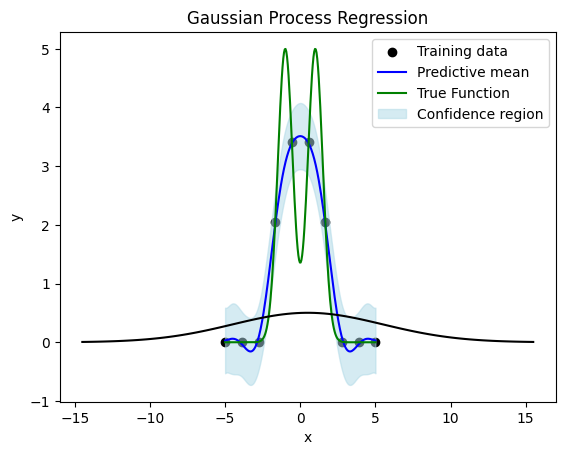

In [3]:
objective = lambda x: -x**2
#objective = lambda x: -20.0 * torch.exp(-0.2 * torch.sqrt(0.5 * x**2))-torch.exp(0.5 * (torch.cos(2*torch.pi*x))) + torch.exp(torch.tensor(1.)) + 20
objective = lambda x: -Ackley(1)(x) 
objective = lambda x: 5*torch.exp(-2*(x - 1)**2) + 5*torch.exp(-2*(x + 1)**2)

from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

mean_distrib, var_distrib = torch.tensor([0.5]), torch.diag(torch.tensor([5.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 10
bounds = 5
lb, up= -5., 5.
train_X = torch.linspace(-bounds,bounds, n, dtype=torch.float64).reshape(-1,1)
#train_Y = (objective(train_X)).sum(dim=1, keepdim=True)
train_Y = objective(train_X).reshape(-1,1)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y = None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


plot_GP_fit(model, quad_distrib, train_X, train_Y, objective, normalize=NORMALIZE, lb=lb, up=up, mean_Y=mean_Y, std_Y=std_Y)

In [4]:
quad = Quadrature(model=model,
            distribution=quad_distrib)
quad.quadrature()
quad.gradient_direction()

def posterior_quad(theta, var):
    mean_distrib_test, var_distrib_test = torch.tensor([theta], dtype=torch.float64), torch.diag(torch.tensor([var], dtype=torch.float64))
    quad_distrib_test = MultivariateNormal(mean_distrib_test, var_distrib_test)
    quad_test = Quadrature(model=model,
            distribution=quad_distrib_test)
    
    quad_test.quadrature()
    return quad_test.m, quad_test.v

/home/pierreo/semisupervised/module/quadrature.py:68: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  self.mean_1 = self.model.mean_module.constant + (self.t_1X.T @ self.inverse_data_covar_y)


In [5]:
b = np.arange(-bounds, bounds, 0.25)
d = np.arange(0, 2, 0.05)[1:]**2
B, D = np.meshgrid(b, d)
n, m = b.shape[0], d.shape[0]
res = torch.stack((torch.tensor(B.flatten()), torch.tensor(D.flatten())), axis = 1).numpy()
result, result_ei, result_wolfe = [], [], []
result_ei = []
for el in tqdm(res):
    post = posterior_quad(el[0], el[1])
    result.append(post)
    mean_joint, covar_joint = quad.compute_joint_distribution_zero_order(torch.tensor([el[0]]), torch.tensor([[el[1]]]))
    result_ei.append(EI(mean_joint, covar_joint))
    
mean, var = torch.tensor(result).numpy()[:,0].reshape(m,n), torch.tensor(result).numpy()[:,1].reshape(m,n)
ei = torch.tensor(result_ei).numpy().reshape(m,n)

  0%|          | 0/1560 [00:00<?, ?it/s]/home/pierreo/semisupervised/module/utils.py:389: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1691.)
  _ = torch.cholesky(B)
100%|██████████| 1560/1560 [00:03<00:00, 472.28it/s]


In [6]:
t_linspace = torch.linspace(0., 100., 200, dtype=train_X.dtype)[1:]
result_wolfe = []
for t in t_linspace:
    result_wolfe.append(quad.compute_p_wolfe(t))
wolfe_tensor = torch.tensor(result_wolfe)

In [7]:
## Compute gradients at multiple places
b_grad = np.arange(-10, 10, 1)
d_grad = np.arange(1e-10, 6, 0.5)
B_grad, D_grad = np.meshgrid(b_grad, d_grad)
n_grad, m_grad = b_grad.shape[0], d_grad.shape[0]
res_grad = torch.stack((torch.tensor(B_grad.flatten()), torch.tensor(D_grad.flatten())), axis = 1).numpy()
result_grad, max_length = [], 0
for el in tqdm(res_grad):
    mean_distrib_grad, var_distrib_grad = torch.tensor([el[0]], dtype=torch.float64), torch.diag(torch.tensor([el[1]], dtype=torch.float64))
    quad_distrib_grad = MultivariateNormal(mean_distrib_grad, var_distrib_grad)
    quad_grad = Quadrature(model=model,
            distribution=quad_distrib_grad)
    quad_grad.quadrature()
    quad_grad.gradient_direction()
    mu_grad, epsilon_grad = float(quad_grad.d_mu.detach().clone()), float(quad_grad.d_epsilon.detach().clone())
    max_length = max(max_length, np.sqrt(mu_grad**2 + epsilon_grad**2))
    result_grad.append([mu_grad, epsilon_grad])

100%|██████████| 240/240 [00:00<00:00, 686.30it/s]


0it [00:00, ?it/s]

240it [00:00, 2956.29it/s]


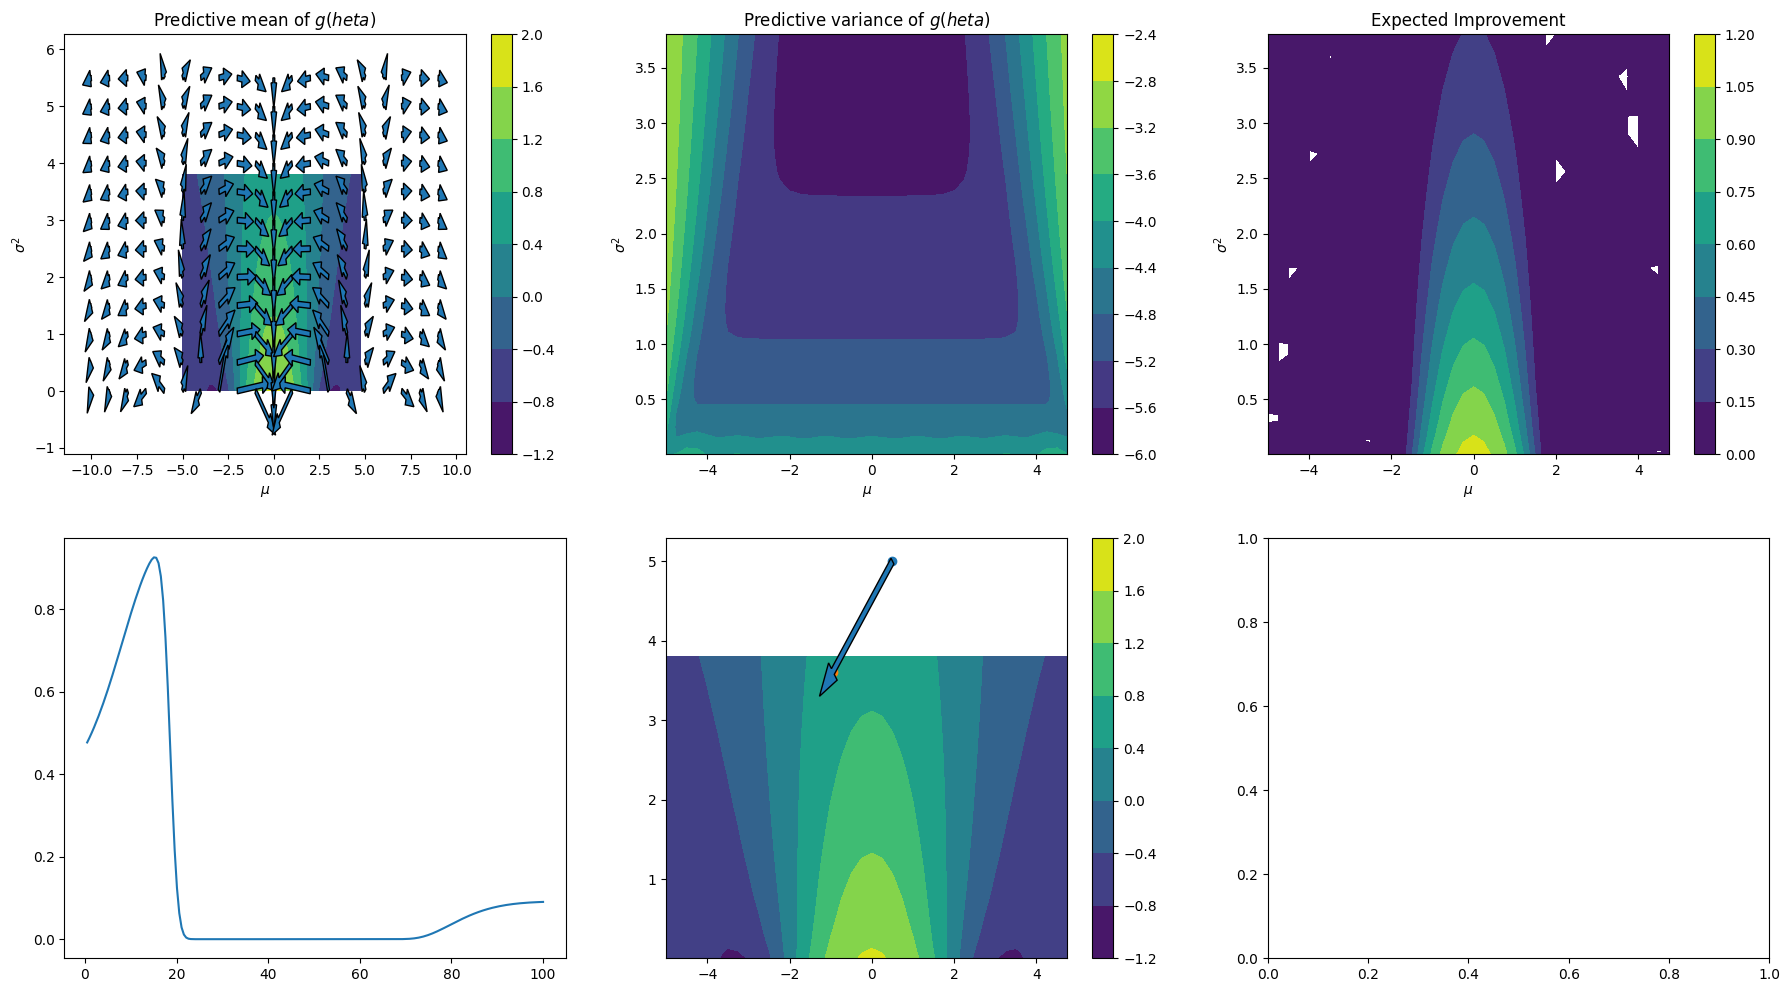

In [8]:
"""
Plot the following:
- Predictive mean and var of g(theta)
- Plot gradient of g(theta) at multiple places
- Plot (max) acquisition function?
- Plot wolfe condition given these plots
"""
#plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 3, figsize=(22, 12))

contour1 = axs[0,0].contourf(B, D, mean)
# Gradient
for i, el in tqdm(enumerate(res_grad)):
    axs[0, 0].arrow(el[0], el[1], result_grad[i][0], result_grad[i][1], width = 0.1)
axs[0,0].set_xlabel('$\mu$')
axs[0,0].set_ylabel('$\sigma^{2}$')
axs[0,0].set_title("Predictive mean of $g(\theta)$")

contour2 = axs[0, 1].contourf(B, D, np.log(var))
axs[0, 1].set_xlabel('$\mu$')
axs[0, 1].set_ylabel('$\sigma^{2}$')
axs[0, 1].set_title("Predictive variance of $g(\theta)$")

contour3 = axs[0,2].contourf(B, D, ei)
axs[0,2].set_xlabel('$\mu$')
axs[0,2].set_ylabel('$\sigma^{2}$')
axs[0,2].set_title("Expected Improvement")


contour4 = axs[1,1].contourf(B, D, mean)
mu2 = float(quad.distribution.loc + float(t_linspace[np.argmax(wolfe_tensor)])*quad.d_mu)
Epsilon2 = float(nearestPD(quad.distribution.covariance_matrix + float(t_linspace[np.argmax(wolfe_tensor)])*quad.d_epsilon))

axs[1,0].plot(t_linspace.numpy(), wolfe_tensor.numpy())
axs[1,1].scatter([float(quad.distribution.loc)], [float(quad.distribution.covariance_matrix)])
axs[1,1].scatter([mu2], [Epsilon2])
axs[1,1].arrow(float(quad.distribution.loc), float(quad.distribution.covariance_matrix), float(t_linspace[np.argmax(wolfe_tensor)]*quad.d_mu), float(t_linspace[np.argmax(wolfe_tensor)]*quad.d_epsilon), width = 0.1)

fig.colorbar(contour1, ax=axs[0,0])
fig.colorbar(contour2, ax=axs[0,1])
fig.colorbar(contour3, ax=axs[0,2])
fig.colorbar(contour4, ax=axs[1,1])

## Second test mu is zero

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


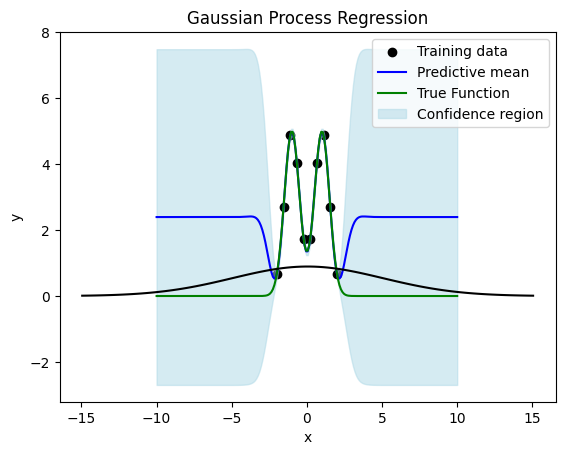

/home/osselinp/semisupervised/module/quadrature.py:63: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  self.mean_1 = self.model.mean_module.constant + (self.t_1X.T @ self.inverse_data_covar_y)
100%|██████████| 3120/3120 [00:14<00:00, 211.56it/s]
/home/osselinp/semisupervised/module/utils.py:382: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite)

Error in callback <function _draw_all_if_interactive at 0x7f6828975c60> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2200x1200 with 10 Axes>

In [3]:
# Plot quadrature value and gradient in 1D case
objective = lambda x: -x**2
#objective = lambda x: -20.0 * torch.exp(-0.2 * torch.sqrt(0.5 * x**2))-torch.exp(0.5 * (torch.cos(2*torch.pi*x))) + torch.exp(torch.tensor(1.)) + 20
objective = lambda x: -Ackley(1)(x) 
objective = lambda x: 5*torch.exp(-2*(x - 1)**2) + 5*torch.exp(-2*(x + 1)**2)

from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

mean_distrib, var_distrib = torch.tensor([0.05]), torch.diag(torch.tensor([5.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 10
bounds = 2
lb, up= -10., 10.
train_X = torch.linspace(-bounds,bounds, n, dtype=torch.float64).reshape(-1,1)
#train_Y = (objective(train_X)).sum(dim=1, keepdim=True)
train_Y = objective(train_X).reshape(-1,1)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y = None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


plot_GP_fit(model, quad_distrib, train_X, train_Y, objective, normalize=NORMALIZE, lb=lb, up=up, mean_Y=mean_Y, std_Y=std_Y)
quad = Quadrature(model=model,
            distribution=quad_distrib, 
            t_max = 200, 
            budget = 200)
quad.quadrature()
quad.gradient_direction()

def posterior_quad(theta, var):
    mean_distrib_test, var_distrib_test = torch.tensor([theta], dtype=torch.float64), torch.diag(torch.tensor([var], dtype=torch.float64))
    quad_distrib_test = MultivariateNormal(mean_distrib_test, var_distrib_test)
    quad_test = Quadrature(model=model,
            distribution=quad_distrib_test)
    
    quad_test.quadrature()
    return quad_test.m, quad_test.v

from scipy.stats import norm
def expected_improvement(theta, var, y_max, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X. 
    '''
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    if var == 0.0:
            return 0.0
    
    with np.errstate(divide='warn'):
        imp = theta - y_max - xi
        Z = imp / var
        ei = imp * norm.cdf(Z) + var * norm.pdf(Z)
    return ei
b = np.arange(-10, 10, 0.25)
d = np.arange(0, 2, 0.05)[1:]**2
B, D = np.meshgrid(b, d)
n, m = b.shape[0], d.shape[0]
res = torch.stack((torch.tensor(B.flatten()), torch.tensor(D.flatten())), axis = 1).numpy()
result, result_ei, result_wolfe = [], [], []
result_ei = []
for el in tqdm(res):
    post = posterior_quad(el[0], el[1])
    result.append(post)
    result_ei.append(expected_improvement(post[0].detach().numpy(), np.sqrt(post[1].detach().numpy()), torch.max(train_Y).numpy()))
    
mean, var = torch.tensor(result).numpy()[:,0].reshape(m,n), torch.tensor(result).numpy()[:,1].reshape(m,n)
ei = torch.tensor(result_ei).numpy().reshape(m,n)
t_linspace = torch.linspace(-20., 300., 200, dtype=train_X.dtype)
result_wolfe = []
for t in t_linspace:
    result_wolfe.append(quad.compute_p_wolfe(t))
wolfe_tensor = torch.tensor(result_wolfe)
## Compute gradients at multiple places
b_grad = np.arange(-10, 10, 1)
d_grad = np.arange(0, 6, 0.5)[1:]
B_grad, D_grad = np.meshgrid(b_grad, d_grad)
n_grad, m_grad = b_grad.shape[0], d_grad.shape[0]
res_grad = torch.stack((torch.tensor(B_grad.flatten()), torch.tensor(D_grad.flatten())), axis = 1).numpy()
result_grad, max_length = [], 0
for el in tqdm(res_grad):
    mean_distrib_grad, var_distrib_grad = torch.tensor([el[0]], dtype=torch.float64), torch.diag(torch.tensor([el[1]], dtype=torch.float64))
    quad_distrib_grad = MultivariateNormal(mean_distrib_grad, var_distrib_grad)
    quad_grad = Quadrature(model=model,
            distribution=quad_distrib_grad)
    quad_grad.quadrature()
    quad_grad.gradient_direction()
    mu_grad, epsilon_grad = float(quad_grad.d_mu.detach().clone()), float(quad_grad.d_epsilon.detach().clone())
    max_length = max(max_length, np.sqrt(mu_grad**2 + epsilon_grad**2))
    result_grad.append([mu_grad, epsilon_grad])
"""
Plot the following:
- Predictive mean and var of g(theta)
- Plot gradient of g(theta) at multiple places
- Plot (max) acquisition function?
- Plot wolfe condition given these plots
"""
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 3, figsize=(22, 12))

contour1 = axs[0,0].contourf(B, D, mean)
# Gradient
for i, el in tqdm(enumerate(res_grad)):
    axs[0, 0].arrow(el[0], el[1], result_grad[i][0], result_grad[i][1], width = 0.1)
axs[0,0].set_xlabel(r'$\mu$')
axs[0,0].set_ylabel(r'$\sigma^{2}$')
axs[0,0].set_title(r"Predictive mean of $g(\theta)$")

contour2 = axs[0, 1].contourf(B, D, np.log(var))
axs[0, 1].set_xlabel(r'$\mu$')
axs[0, 1].set_ylabel(r'$\sigma^{2}$')
axs[0, 1].set_title(r"Predictive variance of $g(\theta)$")

contour3 = axs[0,2].contourf(B, D, ei)
axs[0,2].set_xlabel(r'$\mu$')
axs[0,2].set_ylabel(r'$\sigma^{2}$')
axs[0,2].set_title(r"Expected Improvement")


contour4 = axs[1,1].contourf(B, D, mean)
mu2 = float(quad.distribution.loc + float(t_linspace[np.argmax(wolfe_tensor)])*quad.d_mu)
Epsilon2 = float(nearestPD(quad.distribution.covariance_matrix + float(t_linspace[np.argmax(wolfe_tensor)])*quad.d_epsilon))

axs[1,0].plot(t_linspace.numpy(), wolfe_tensor.numpy())
axs[1,1].scatter([float(quad.distribution.loc)], [float(quad.distribution.covariance_matrix)])
axs[1,1].scatter([mu2], [Epsilon2])
axs[1,1].arrow(float(quad.distribution.loc), float(quad.distribution.covariance_matrix), float(t_linspace[np.argmax(wolfe_tensor)]*quad.d_mu), float(t_linspace[np.argmax(wolfe_tensor)]*quad.d_epsilon), width = 0.1)

fig.colorbar(contour1, ax=axs[0,0])
fig.colorbar(contour2, ax=axs[0,1])
fig.colorbar(contour3, ax=axs[0,2])
fig.colorbar(contour4, ax=axs[1,1])


In [6]:
plt.plot(t_linspace.numpy(), wolfe_tensor.numpy())

Error in callback <function _draw_all_if_interactive at 0x7f6828975c60> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

In [4]:
quad.maximize_step()
quad.t_max

tensor(187., dtype=torch.float64)

In [ ]:
t_linspace[np.argmax(wolfe_tensor)]*quad.d_epsilon

# Plot quadrature value and gradient in 1D case

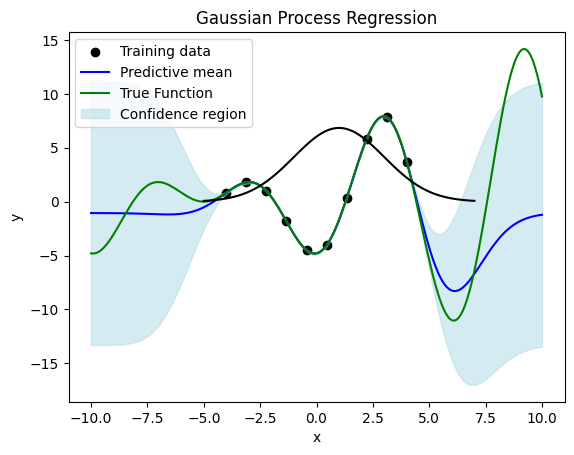

In [6]:
objective = lambda x: (x + 5) * torch.sin(x + 5)

from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior
from botorch.optim import optimize_acqf


mean_distrib, var_distrib = torch.tensor([1.]), torch.diag(torch.tensor([2.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 10
bounds = 4
lb, up= -10., 10.
train_X = torch.linspace(-bounds,bounds, n, dtype=torch.float64).reshape(-1,1)
train_Y = (objective(train_X)).sum(dim=1, keepdim=True)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y = None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


plot_GP_fit(model, quad_distrib, train_X, train_Y, objective, normalize=NORMALIZE, lb=lb, up=up, mean_Y=mean_Y, std_Y=std_Y)

In [4]:
quad = Quadrature(model=model,
            distribution=quad_distrib,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 50,
            budget = 500)
quad.quadrature()
quad.gradient_direction()

def posterior_quad(theta, var):
    mean_distrib_test, var_distrib_test = torch.tensor([theta], dtype=torch.float64), torch.diag(torch.tensor([var], dtype=torch.float64))
    quad_distrib_test = MultivariateNormal(mean_distrib_test, var_distrib_test)
    quad_test = Quadrature(model=model,
            distribution=quad_distrib_test,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 1,
            budget = 50)
    
    quad_test.quadrature()
    return quad_test.m, quad_test.v

from scipy.stats import norm
def expected_improvement(theta, var, y_max, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    if var == 0.0:
            return 0.0
    
    with np.errstate(divide='warn'):
        imp = theta - y_max - xi
        Z = imp / var
        ei = imp * norm.cdf(Z) + var * norm.pdf(Z)
    return ei

/home/pierre/git/semisupervised/module/quadrature.py:61: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  self.mean_1 = self.model.mean_module.constant + (self.t_1X.T @ self.inverse_data_covar_y)


In [5]:
b = np.arange(-10, 10, 0.25)
d = np.arange(0, 2, 0.05)[1:]**2
B, D = np.meshgrid(b, d)
n, m = b.shape[0], d.shape[0]
res = torch.stack((torch.tensor(B.flatten()), torch.tensor(D.flatten())), axis = 1).numpy()
result, result_ei, result_wolfe = [], [], []
result_ei = []
for el in tqdm(res):
    post = posterior_quad(el[0], el[1])
    result.append(post)
    result_ei.append(expected_improvement(post[0].detach().numpy(), np.sqrt(post[1].detach().numpy()), torch.max(train_Y).numpy()))
    
mean, var = torch.tensor(result).numpy()[:,0].reshape(m,n), torch.tensor(result).numpy()[:,1].reshape(m,n)
ei = torch.tensor(result_ei).numpy().reshape(m,n)

  0%|          | 0/3120 [00:00<?, ?it/s]

100%|██████████| 3120/3120 [00:07<00:00, 436.80it/s]


In [6]:
t_linspace = torch.linspace(-10., 10., 200, dtype=train_X.dtype)
result_wolfe = []
for t in t_linspace:
    result_wolfe.append(quad.compute_p_wolfe(t))
wolfe_tensor = torch.tensor(result_wolfe)

/home/pierre/git/semisupervised/module/utils.py:382: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1615.)
  _ = torch.cholesky(B)


In [7]:
## Compute gradients at multiple places
b_grad = np.arange(-10, 10, 2)
d_grad = np.arange(0, 2, 1)[1:]**2
B_grad, D_grad = np.meshgrid(b_grad, d_grad)
n_grad, m_grad = b_grad.shape[0], d_grad.shape[0]
res_grad = torch.stack((torch.tensor(B_grad.flatten()), torch.tensor(D_grad.flatten())), axis = 1).numpy()
result_grad, max_length = [], 0
for el in tqdm(res_grad):
    mean_distrib_grad, var_distrib_grad = torch.tensor([el[0]], dtype=torch.float64), torch.diag(torch.tensor([el[1]], dtype=torch.float64))
    quad_distrib_grad = MultivariateNormal(mean_distrib_grad, var_distrib_grad)
    quad_grad = Quadrature(model=model,
            distribution=quad_distrib_grad,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 1,
            budget = 50)
    quad_grad.quadrature()
    quad_grad.gradient_direction()
    mu_grad, epsilon_grad = float(quad_grad.d_mu.detach().clone()), float(quad_grad.d_epsilon.detach().clone())
    max_length = max(max_length, np.sqrt(mu_grad**2 + epsilon_grad**2))
    result_grad.append([mu_grad, epsilon_grad])

100%|██████████| 10/10 [00:00<00:00, 367.26it/s]


10it [00:00, 1373.83it/s]


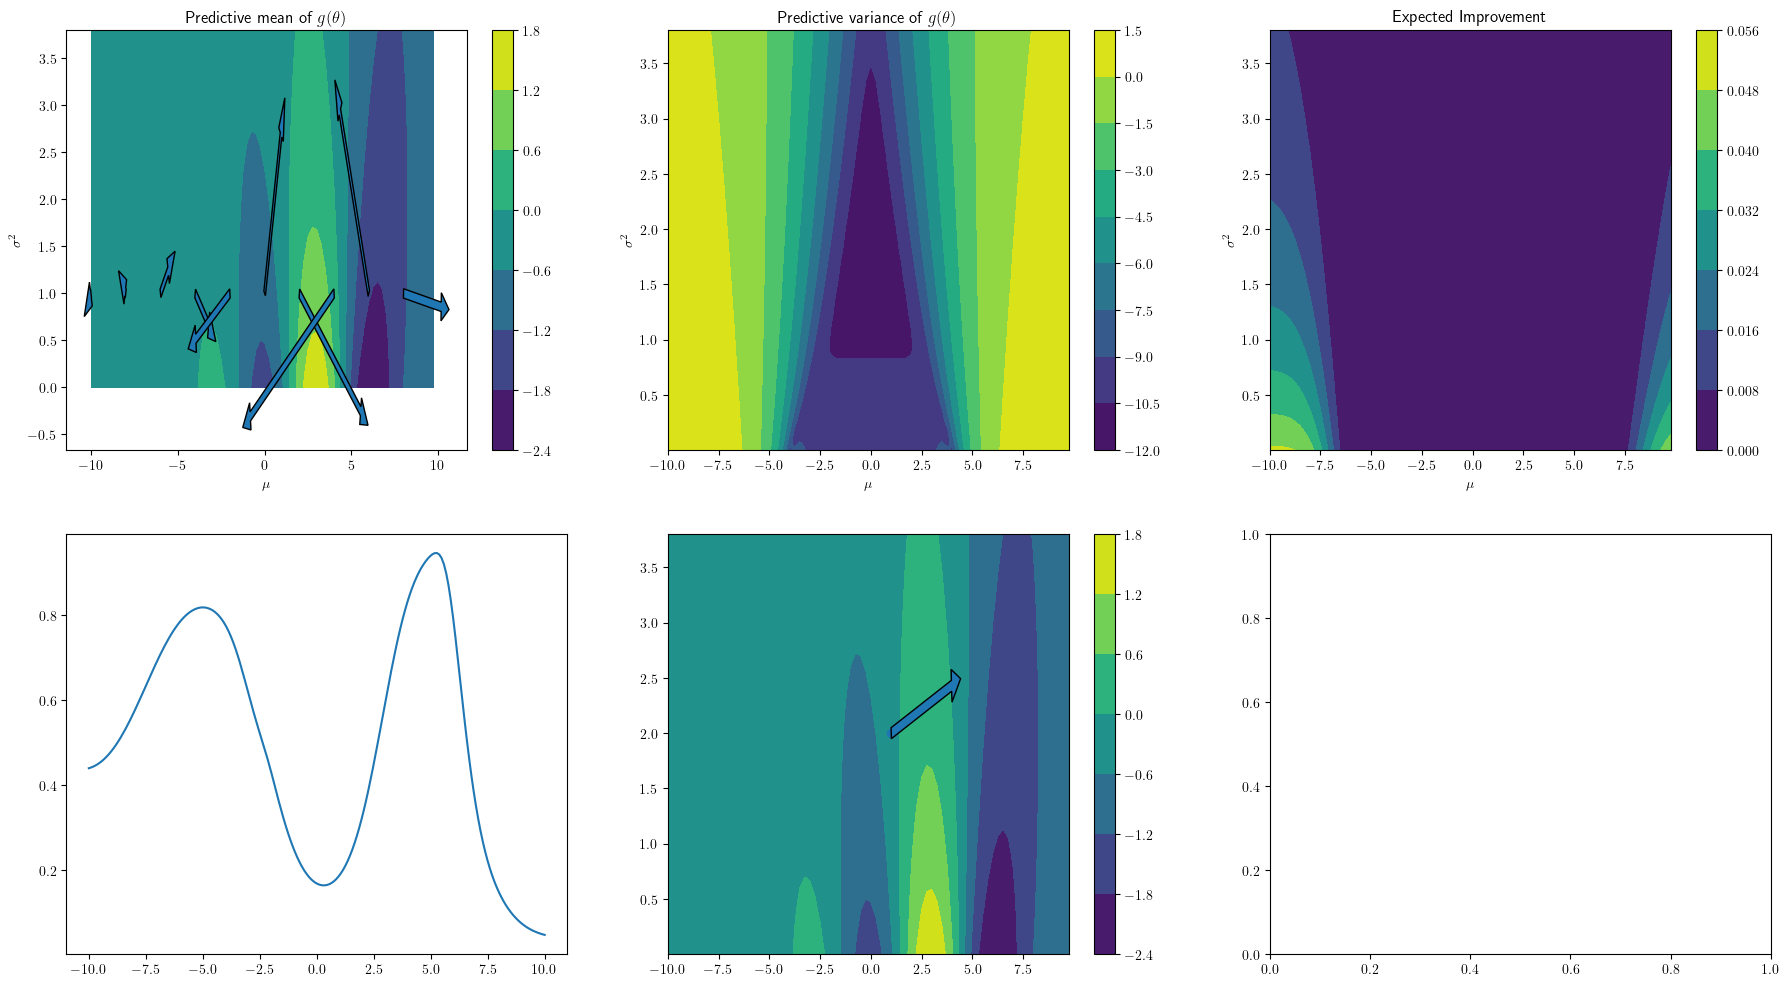

In [8]:
"""
Plot the following:
- Predictive mean and var of g(theta)
- Plot gradient of g(theta) at multiple places
- Plot (max) acquisition function?
- Plot wolfe condition given these plots
"""
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 3, figsize=(22, 12))

contour1 = axs[0,0].contourf(B, D, mean)
# Gradient
arrow_factor = 5
for i, el in tqdm(enumerate(res_grad)):
    axs[0, 0].arrow(el[0], el[1], arrow_factor*result_grad[i][0]/max_length, arrow_factor*result_grad[i][1]/max_length, width = 0.1)
axs[0,0].set_xlabel(r'$\mu$')
axs[0,0].set_ylabel(r'$\sigma^{2}$')
axs[0,0].set_title(r"Predictive mean of $g(\theta)$")

contour2 = axs[0, 1].contourf(B, D, np.log(var))
axs[0, 1].set_xlabel(r'$\mu$')
axs[0, 1].set_ylabel(r'$\sigma^{2}$')
axs[0, 1].set_title(r"Predictive variance of $g(\theta)$")

contour3 = axs[0,2].contourf(B, D, ei)
axs[0,2].set_xlabel(r'$\mu$')
axs[0,2].set_ylabel(r'$\sigma^{2}$')
axs[0,2].set_title(r"Expected Improvement")


contour4 = axs[1,1].contourf(B, D, mean)
mu2 = float(quad.distribution.loc + float(t_linspace[np.argmax(wolfe_tensor)])*quad.d_mu)
Epsilon2 = float(nearestPD(quad.distribution.covariance_matrix + float(t_linspace[np.argmax(wolfe_tensor)])*quad.d_epsilon))

axs[1,0].plot(t_linspace.numpy(), wolfe_tensor.numpy())
axs[1,1].scatter([float(quad.distribution.loc)], [float(quad.distribution.covariance_matrix)])
axs[1,1].scatter([mu2], [Epsilon2])
axs[1,1].arrow(float(quad.distribution.loc), float(quad.distribution.covariance_matrix), float(t_linspace[np.argmax(wolfe_tensor)]*quad.d_mu), float(t_linspace[np.argmax(wolfe_tensor)]*quad.d_epsilon), width = 0.1)

fig.colorbar(contour1, ax=axs[0,0])
fig.colorbar(contour2, ax=axs[0,1])
fig.colorbar(contour3, ax=axs[0,2])
fig.colorbar(contour4, ax=axs[1,1])

In [9]:
t_linspace[np.argmax(wolfe_tensor)]

tensor(3.3668, dtype=torch.float64)

# Plot result from acquisition function maximization

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


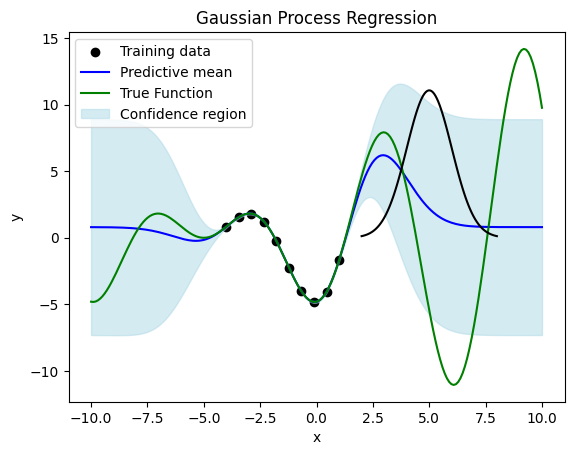

In [4]:
objective = lambda x: (x + 5) * torch.sin(x + 5)

from botorch import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

mean_distrib, var_distrib = torch.tensor([5.]), torch.diag(torch.tensor([1.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 10
bounds = 4
lb, up= -10., 10.
train_X = torch.linspace(-bounds,1., n, dtype=torch.float64).reshape(-1,1)
train_Y = (objective(train_X)).sum(dim=1, keepdim=True)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y = None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


plot_GP_fit(model, quad_distrib, train_X, train_Y, objective, normalize=NORMALIZE, lb=lb, up=up, mean_Y=mean_Y, std_Y=std_Y)

In [4]:
BATCH_SIZE = 1
N_BATCH = 15

# Algorithm setting
NUM_RESTARTS = 10
RAW_SAMPLES = 512
MC_SAMPLES = 256
ACQUISITION_BATCH_OPTIMIZATION = 3
NORMALIZE = False
STANDARDIZE_LABEL = True
VERBOSE = True

def optimize_acqf_and_get_observation(acq_func):
        """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
        # optimize
        if NORMALIZE:
            bounds=torch.stack(
                [
                    torch.zeros(1, dtype=torch.float64),
                    torch.ones(1, dtype=torch.float64),
                ])
        else:
            bounds=torch.tensor([[-10.], [10.]], dtype=torch.float64)

        candidates, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=BATCH_SIZE,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,  # used for intialization heuristic
            options={"batch_limit": ACQUISITION_BATCH_OPTIMIZATION, "maxiter": 200},
        )
        # observe new values 
        new_x = candidates
        exact_obj = objective(new_x).unsqueeze(-1) # add output dimension
        new_obj = exact_obj
        return new_x, new_obj

In [5]:
quad = Quadrature(model=model,
            distribution=quad_distrib,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 1,
            budget = 50)
quad.quadrature()
acq = QuadratureExplorationBis(model=model, distribution= quad_distrib)
new_x, new_obj = optimize_acqf_and_get_observation(acq)

/home/pierre/git/semisupervised/module/quadrature.py:61: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  self.mean_1 = self.model.mean_module.constant + (self.t_1X.T @ self.inverse_data_covar_y)
